In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely.wkt
from shapely.geometry import MultiPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
!wget -qNP data https://data.rivm.nl/covid-19/COVID-19_aantallen_gemeente_cumulatief.csv

In [3]:
df = pd.read_csv("data\COVID-19_aantallen_gemeente_cumulatief.csv", sep=';')
datum = df.Date_of_report[len(df.Date_of_report)-1]
df.head()

,Date_of_report,Municipality_code,Municipality_name,Province,Total_reported,Hospital_admission,Deceased
0,2020-03-13 10:00:00,GM0003,Appingedam,Groningen,0,0,0
1,2020-03-13 10:00:00,GM0010,Delfzijl,Groningen,0,0,0
2,2020-03-13 10:00:00,GM0014,Groningen,Groningen,3,0,0
3,2020-03-13 10:00:00,GM0024,Loppersum,Groningen,0,0,0
4,2020-03-13 10:00:00,GM0034,Almere,Flevoland,1,1,0


In [4]:
print("Aantal gemeenten:", df['Municipality_name'].unique().shape[0])
print("Totaal gemeld:", df[df.Date_of_report == datum]['Total_reported'].sum())
print("Total overleden:", df[df.Date_of_report == datum]['Deceased'].sum())

Aantal gemeenten: 356
Totaal gemeld: 787300
Total overleden: 11324


In [5]:
top_reported = df[df.Date_of_report == datum][['Municipality_code', 'Municipality_name', 'Total_reported']].sort_values('Total_reported', ascending=False).reset_index(drop=True)
top_reported.index = np.arange(1, len(top_reported) + 1)
top_reported.head(10)

,Municipality_code,Municipality_name,Total_reported
1,GM0363,Amsterdam,50925
2,GM0599,Rotterdam,41698
3,GM0518,'s-Gravenhage,28296
4,GM0344,Utrecht,17723
5,GM0855,Tilburg,10895
6,GM0034,Almere,10478
7,GM0772,Eindhoven,9545
8,GM0758,Breda,8601
9,GM0479,Zaanstad,8053
10,GM0307,Amersfoort,7511


In [6]:
top_deceased = df[df.Date_of_report == datum][['Municipality_code', 'Municipality_name', 'Deceased']].sort_values('Deceased', ascending=False).reset_index(drop=True)
top_deceased.index = np.arange(1, len(top_deceased) + 1)
top_deceased.head(10)

,Municipality_code,Municipality_name,Deceased
1,GM0599,Rotterdam,672
2,GM0363,Amsterdam,495
3,GM0518,'s-Gravenhage,417
4,GM0855,Tilburg,244
5,GM0344,Utrecht,186
6,GM0772,Eindhoven,171
7,GM0935,Maastricht,155
8,GM1948,Meierijstad,148
9,GM0268,Nijmegen,130
10,GM0796,'s-Hertogenbosch,127


In [7]:
# dc = pd.read_csv("vw_nl_covid_19_aantallen_gemeente_cumulatief.csv", usecols=[2,4,5,6])
# columns = ['gemeente_code', 'gemeente_naam', 'bevolking_2020', 'shape']
# dc = dc[columns]
# dc.columns = ['Municipality_code', 'Municipality_name', 'Population_2020', 'Shape']
# dc.head()
# dc.to_csv("COVID-19_coordinaten_gemeente.csv", index=False)

In [8]:
locations = pd.read_csv("data\COVID-19_coordinaten_gemeente.csv")
locations.head()

,Municipality_code,Municipality_name,Population_2020,Shape
0,GM0230,Elburg,23161,MULTIPOLYGON (((183794.87999999896 494357.1829...
1,GM1581,Utrechtse Heuvelrug,49601,MULTIPOLYGON (((151257.51099999994 454497.8770...
2,GM0840,Rucphen,22873,MULTIPOLYGON (((93856.13300000131 395351.14499...
3,GM0417,Laren,11274,MULTIPOLYGON (((142851.7349999994 475338.44500...
4,GM0453,Velsen,68660,"MULTIPOLYGON (((97692 495759, 97631 496039, 97..."


In [23]:
reported = pd.merge(top_reported, locations, how='inner', on='Municipality_code', suffixes=('', '_copy')).drop('Municipality_name_copy', axis=1)
reported.tail()

,Municipality_code,Municipality_name,Total_reported,Population_2020,Shape
350,GM0060,Ameland,112,3718,"MULTIPOLYGON (((166000 609500, 170000 612000, ..."
351,GM0093,Terschelling,84,4889,"MULTIPOLYGON (((166000 609500, 168000 608000, ..."
352,GM0277,Rozendaal,61,1705,MULTIPOLYGON (((192800.77299999818 450175.0210...
353,GM0096,Vlieland,21,1152,"MULTIPOLYGON (((131000 592000, 135000 593000, ..."
354,GM0088,Schiermonnikoog,7,947,"MULTIPOLYGON (((208649.2899999991 603300, 2074..."


In [24]:
bins = [0, 100, 1000, 10000, reported['Total_reported'].max()]
labels = ['0-1000', '1000-10000', '10000-100000', '>100000']
reported['binned'] = pd.cut(reported['Total_reported'], bins=bins, labels=labels)
reported[['Total_reported', 'binned']].head()

,Total_reported,binned
0,50925,>100000
1,41698,>100000
2,28296,>100000
3,17723,>100000
4,10895,>100000


In [25]:
geometry = reported['Shape'].map(shapely.wkt.loads)
reported = reported.drop('Shape', axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(reported, crs=crs, geometry=geometry)
#gdf.drop(columns=['FID', 'datum_bestand'], inplace=True)

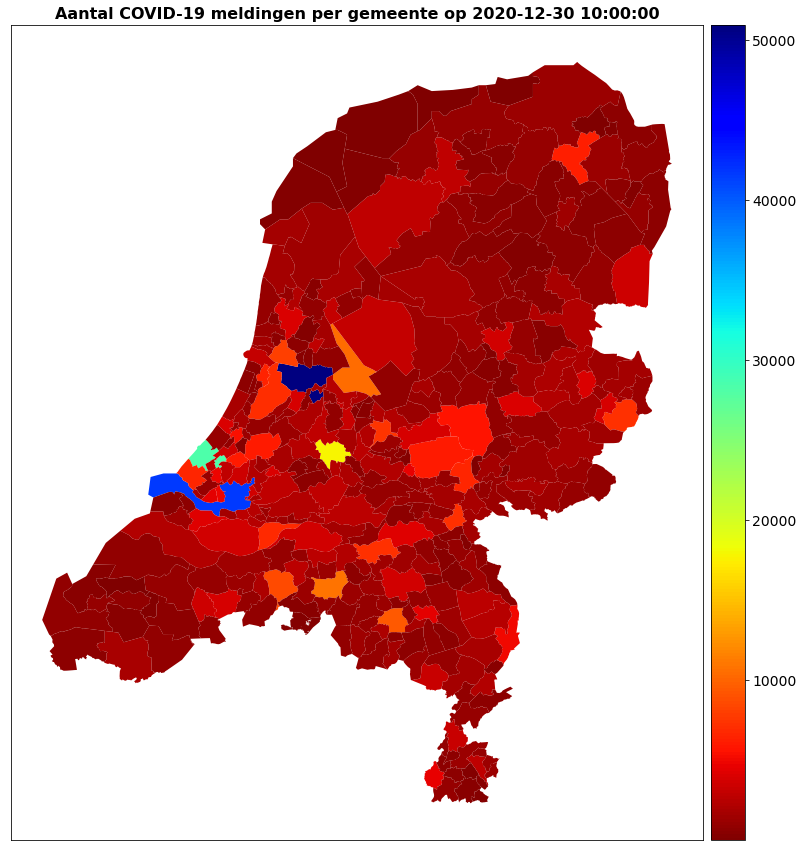

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
gdf.plot(column='Total_reported', ax=ax, legend=True, cmap='jet_r', cax=cax)
ax.set_title(f"Aantal COVID-19 meldingen per gemeente op {datum}", fontsize=16, fontweight="bold")
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.tick_params(axis="y", labelsize=14)
plt.show()

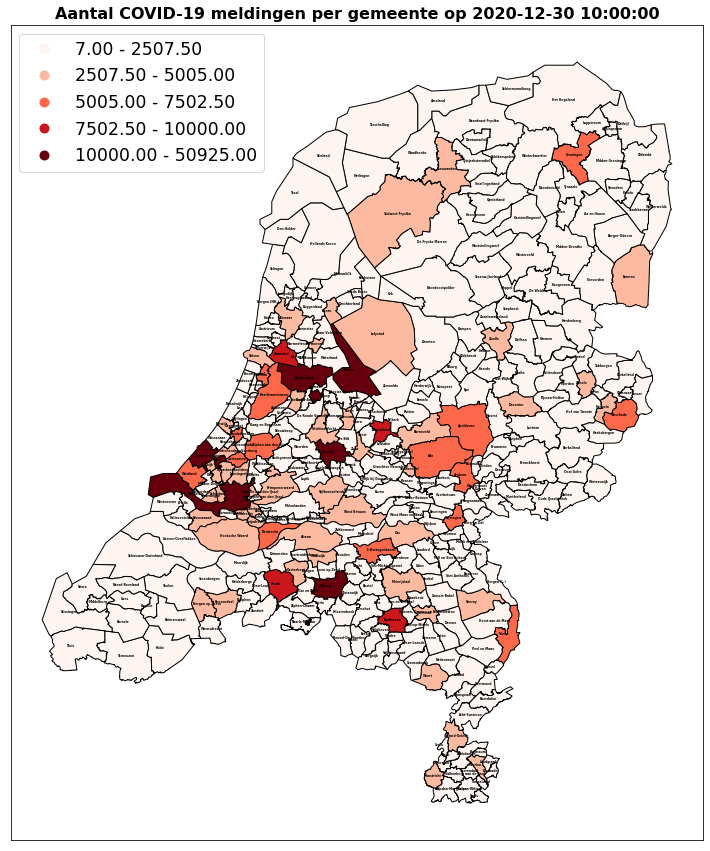

In [27]:
import mapclassify
bins = mapclassify.EqualInterval(np.logspace(1, 4, 4), k=4).bins
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
gdf.plot(column='Total_reported', ax=ax, legend=True, \
         legend_kwds={'loc': 'upper left', 'fontsize':'xx-large'} \
         , scheme="User_Defined", cmap='Reds', classification_kwds=dict(bins=bins), edgecolor='black')

for x, y, label in zip(gdf.centroid.x, gdf.centroid.y, gdf.Municipality_name):
    ax.annotate(label, xy=(x, y), xytext=(-10, 0), textcoords="offset points", fontsize=3, fontweight='bold')



ax.set_title(f"Aantal COVID-19 meldingen per gemeente op {datum}", fontdict={'fontsize': '16', \
                                                                             'fontweight' : 'bold'})
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.savefig("plots\COVID-19_per_gemeente.pdf", bbox_inches='tight')

In [28]:
gemeenten = pd.merge(df, locations, how='inner', on='Municipality_code', suffixes=('', '_copy')).drop('Municipality_name_copy', axis=1)
gemeenten.tail()

,Date_of_report,Municipality_code,Municipality_name,Province,Total_reported,Hospital_admission,Deceased,Population_2020,Shape
104010,2020-12-26 10:00:00,GM1978,Molenlanden,Zuid-Holland,2188,25,19,43931,MULTIPOLYGON (((118973.34299999848 439192.9600...
104011,2020-12-27 10:00:00,GM1978,Molenlanden,Zuid-Holland,2221,25,19,43931,MULTIPOLYGON (((118973.34299999848 439192.9600...
104012,2020-12-28 10:00:00,GM1978,Molenlanden,Zuid-Holland,2249,25,19,43931,MULTIPOLYGON (((118973.34299999848 439192.9600...
104013,2020-12-29 10:00:00,GM1978,Molenlanden,Zuid-Holland,2274,26,21,43931,MULTIPOLYGON (((118973.34299999848 439192.9600...
104014,2020-12-30 10:00:00,GM1978,Molenlanden,Zuid-Holland,2314,26,21,43931,MULTIPOLYGON (((118973.34299999848 439192.9600...


In [ ]:
# fig = px.choropleth(gemeenten, locations="Municipality_name",
#                     geojson = "Shape",
#                     color="Total_reported",
#                     color_continuous_scale='OrRd', #px.colors.diverging.RdYlGn[::-1],
#                     range_color=[0, np.max(gemeenten.Total_reported)],
#                     animation_frame="Date_of_report",
#                     scope="europe",
#                     title="COVID-19 development in the Netherlands",
#                     height=700)
# fig.show()